In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
img_shape = 128
input_shape = (img_shape, img_shape, 3)
EPOCHS = 10
BATCH_SIZE = 32

In [3]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_arr = None
    if label == 'fake':
        label_arr = 0
    else:
        label_arr = 1
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return (img, label_arr)

def scale(image, label):
    return (image / 255, label)

train_ds = tf.data.Dataset.list_files('1frame/train/*/*')
test_ds = tf.data.Dataset.list_files('1frame/test/*/*')
val_ds = tf.data.Dataset.list_files('1frame/valid/*/*')

train_size = len(train_ds)
val_size = len(val_ds)

train_ds = train_ds.shuffle(train_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).repeat(EPOCHS).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, LeakyReLU, Concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer, Rescaling
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [5]:
inception_resnet = EfficientNetB0(include_top = False, weights = 'imagenet', input_shape = input_shape)
inception_resnet.trainable = True
model = Sequential()
model.add(inception_resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [6]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,070,084
Trainable params: 4,028,061
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_efficentnetb0_1frame.hdf5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_lr = 0.0001)

STEPS = train_size // BATCH_SIZE
callbacks = [checkpoint_callback, reduce_lr]
history = model.fit(train_ds, batch_size = BATCH_SIZE, steps_per_epoch = STEPS, epochs = EPOCHS, callbacks = callbacks, validation_data = val_ds, verbose = 1)

Epoch 1/10
4894/4894 [==============================] - 645s 130ms/step - loss: 0.1884 - accuracy: 0.9287 - val_loss: 0.6892 - val_accuracy: 0.5413

Epoch 00001: val_loss improved from inf to 0.68918, saving model to checkpoints\best_efficentnetb0_1frame.hdf5


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
4894/4894 [==============================] - 598s 122ms/step - loss: 0.1112 - accuracy: 0.9608 - val_loss: 0.6844 - val_accuracy: 0.5561

Epoch 00002: val_loss improved from 0.68918 to 0.68438, saving model to checkpoints\best_efficentnetb0_1frame.hdf5
Epoch 3/10
4894/4894 [==============================] - 617s 126ms/step - loss: 0.0864 - accuracy: 0.9696 - val_loss: 0.7594 - val_accuracy: 0.5387

Epoch 00003: val_loss did not improve from 0.68438
Epoch 4/10
4894/4894 [==============================] - 613s 125ms/step - loss: 0.0695 - accuracy: 0.9753 - val_loss: 0.7200 - val_accuracy: 0.5294

Epoch 00004: val_loss did not improve from 0.68438
Epoch 5/10
4894/4894 [==============================] - 592s 121ms/step - loss: 0.0586 - accuracy: 0.9791 - val_loss: 0.7575 - val_accuracy: 0.6183

Epoch 00005: val_loss did not improve from 0.68438

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
4894/4894 [==============================] 

INFO:tensorflow:Assets written to: models/efficentnetb0_1frame\assets


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


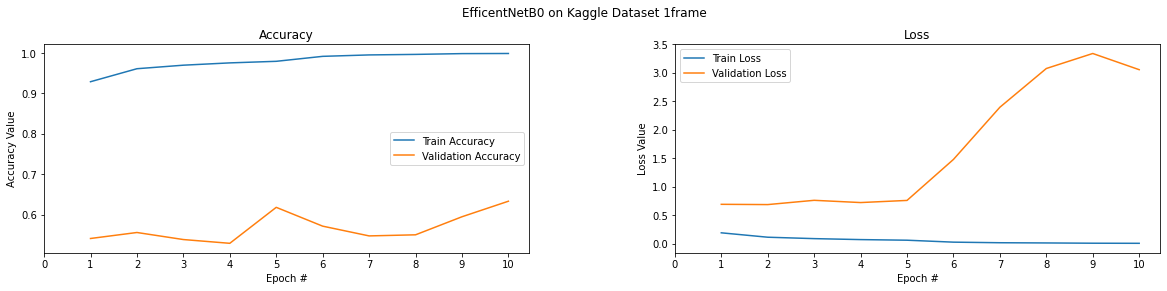

In [8]:
model.save('models/efficentnetb0_1frame')

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4))
t = f.suptitle('EfficentNetB0 on Kaggle Dataset 1frame', fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

epoch_list = list(range(1, EPOCHS + 1))
ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [9]:
results = model.evaluate(test_ds)
print(model.metrics_names)
print(results)

612/612 [==============================] - 18s 29ms/step - loss: 1.0910 - accuracy: 0.8301
['loss', 'accuracy']
[1.090964913368225, 0.8301491737365723]


True positive =  108
False positive =  20
False negative =  24
True negative =  104
Precision =  0.84375
Recall =  0.8181818181818182
Fscore =  0.8307692307692308




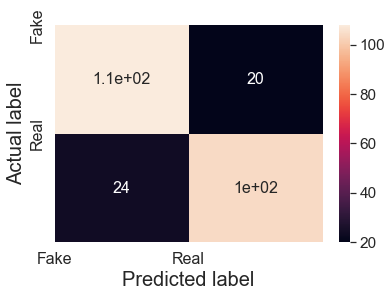

In [10]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)
    print('True positive = ', tp)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True negative = ', tn)
    print('Precision = ', precision)
    print('Recall = ', recall)
    print('Fscore = ', fscore)
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def scale(image):
    return (image / 255)
    
model = load_model('models/efficentnetb0_1frame')
data_dir = '1frame/test'
real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]
real_data = random.sample(real_data, 128)
fake_data = random.sample(fake_data, 128)
X = []
Y = []
for img in real_data:
    res = scale(process_path(data_dir+'/real/'+img))
    X.append(res)
    Y.append(1)
for img in fake_data:
    res = scale(process_path(data_dir+'/fake/'+img))
    X.append(res)
    Y.append(0)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
Y_true = Y
Y_pred = model.predict(X)

print_confusion_matrix(Y_true, np.round(Y_pred))